In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cyclone-2008-data/Nargis_2008-05-07.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-05-04.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-20.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-13.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-28.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-05-06.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-12.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-05-01.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-24.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-05-03.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-05-10.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-22.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-27.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-21.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-23.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-29.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-30.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-11.tif
/kaggle/input/cyclone-2008-d

In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.2 MB/s eta 0:00:00:00:0100:01


/kaggle/input/cyclone-2008-data/Nargis_2008-04-10.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-11.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-12.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-13.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-14.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-15.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-16.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-17.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-18.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-19.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-20.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-21.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-22.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-23.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-24.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-25.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-26.tif
/kaggle/input/cyclone-2008-data/Nargis_2008-04-27.tif
/kaggle/input/cyclone-2008-d

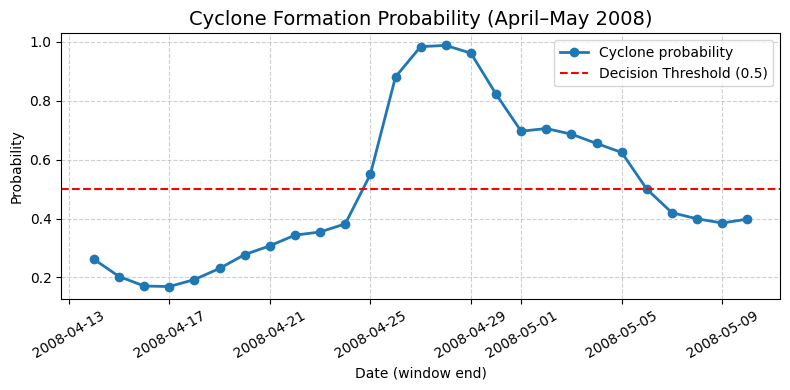

In [9]:
import rasterio
import numpy as np
import glob
import cv2
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt

# -------------------------
# Config
# -------------------------
TIME_STEPS = 5
HEIGHT = 224
WIDTH  = 168
BANDS  = 6
CHANNELS = 7

MODEL_PATH = "/kaggle/input/cyclone_preds_prototype_1/keras/default/1/best_convlstm.keras"
NORM_PATH  = "/kaggle/input/cyclone_preds_prototype_1/keras/default/1/norm_stats_1.npz"
TIF_DIR    = "/kaggle/input/cyclone-2008-data/"

# -------------------------
# Load model & norm stats
# -------------------------
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
norm_stats = np.load(NORM_PATH)
band_means = norm_stats["band_means"]
band_stds  = norm_stats["band_stds"]

# -------------------------
# Load & resize TIFFs
# -------------------------
tif_files = sorted(glob.glob(TIF_DIR + "*.tif"))
all_days = []

for f in tif_files:
    print(f)
    with rasterio.open(f) as src:
        arr = src.read() # (bands, H, W)
        # resize each band from (224,224) -> (224,168)
        resized_bands = []
        for b in arr:
            resized = cv2.resize(b, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
            resized_bands.append(resized)
        arr_resized = np.stack(resized_bands, axis=0)  # (6, 224, 168)
        all_days.append(arr_resized)

X_test_raw = np.stack(all_days, axis=0)  # (10, 6, 224, 168)
print("Loaded & resized test data:", X_test_raw.shape)

# -------------------------
# Build sequences (sliding window of 5 days)
# -------------------------
X_sequences = []
num_days = X_test_raw.shape[0]

for start in range(num_days - TIME_STEPS + 1):
    seq = X_test_raw[start:start+TIME_STEPS]  # (5, 6, H, W)

    # mask from first band
    mask = ~np.isnan(seq[:, 0, :, :])
    mask = mask.astype(np.float32)[:, None, :, :]

    # replace NaNs with 0
    seq = np.nan_to_num(seq, nan=0.0, posinf=0.0, neginf=0.0)

    # normalize
    seq = (seq - band_means[None, :, None, None]) / band_stds[None, :, None, None]

    # concat mask
    seq = np.concatenate([seq, mask], axis=1)   # (T, 7, H, W)

    # to (T, H, W, C)
    seq = np.transpose(seq, (0, 2, 3, 1))

    X_sequences.append(seq)

X_sequences = np.stack(X_sequences, axis=0).astype(np.float32)
print("Test sequences shape:", X_sequences.shape)

# -------------------------
# Predict
# -------------------------
preds = model.predict(X_sequences).ravel()

# -------------------------
# Map predictions to dates
# -------------------------
start_date = datetime.date(2008, 4, 10) 
dates = []
Cyclone_days = []
for i, p in enumerate(preds):
    label = 1 if p > 0.5 else 0
    seq_start = start_date + datetime.timedelta(days=i)
    seq_end   = seq_start + datetime.timedelta(days=TIME_STEPS-1)
    if label == 1:
        Cyclone_days.append((seq_end,p))
    dates.append(seq_end)  # aligns with plot
    print(f"Window {i+1}: {seq_start} → {seq_end} | Prob = {p:.3f} | Predicted Label = {label}")
    
    
# -------------------------
# Plot time series
# -------------------------


plt.figure(figsize=(8,4))
plt.plot(dates, preds, marker="o", linewidth=2, label="Cyclone probability")
plt.axhline(0.5, color="red", linestyle="--", label="Decision Threshold (0.5)")
plt.title("Cyclone Formation Probability (April–May 2008)", fontsize=14)
plt.xlabel("Date (window end)")
plt.ylabel("Probability")
plt.xticks(rotation=30)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
for days,prob in Cyclone_days:
    print(f"Date : {days} , Probability : {prob}")

Date : 2008-04-25 , Probability : 0.5500320792198181
Date : 2008-04-26 , Probability : 0.8812274932861328
Date : 2008-04-27 , Probability : 0.9839493036270142
Date : 2008-04-28 , Probability : 0.988160252571106
Date : 2008-04-29 , Probability : 0.9617881774902344
Date : 2008-04-30 , Probability : 0.8226090669631958
Date : 2008-05-01 , Probability : 0.6966288089752197
Date : 2008-05-02 , Probability : 0.7058433294296265
Date : 2008-05-03 , Probability : 0.6865978837013245
Date : 2008-05-04 , Probability : 0.6551586389541626
Date : 2008-05-05 , Probability : 0.6245868802070618


Detected Cyclone Periods: [(datetime.date(2008, 4, 22), datetime.date(2008, 5, 4))]


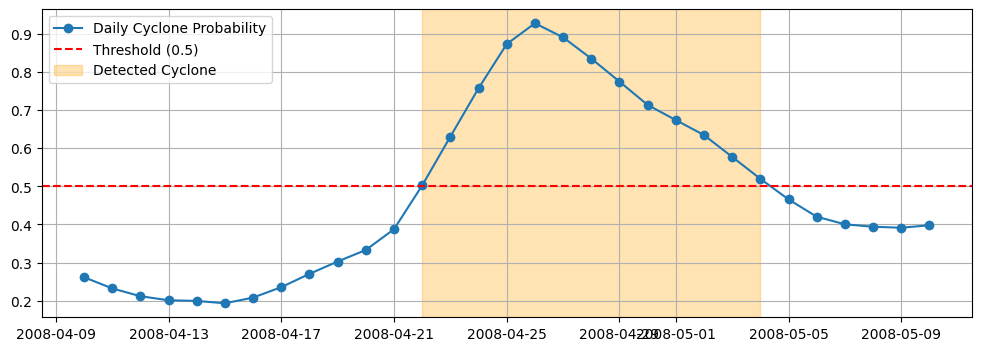

In [14]:
# Convert window predictions -> daily probs
from collections import defaultdict

daily_probs = defaultdict(list)

for i, p in enumerate(preds):
    seq_start = start_date + datetime.timedelta(days=i)
    seq_end   = seq_start + datetime.timedelta(days=TIME_STEPS-1)
    for d in range(TIME_STEPS):
        day = seq_start + datetime.timedelta(days=d)
        daily_probs[day].append(p)

# Average per day
days = sorted(daily_probs.keys())
day_probs = [np.mean(daily_probs[d]) for d in days]

# Detect cyclone periods
threshold = 0.5
in_cyclone = False
cyclone_periods = []
start = None

for d, prob in zip(days, day_probs):
    if prob >= threshold and not in_cyclone:
        start = d
        in_cyclone = True
    elif prob < threshold and in_cyclone:
        cyclone_periods.append((start, d - datetime.timedelta(days=1)))
        in_cyclone = False

# If still ongoing
if in_cyclone:
    cyclone_periods.append((start, days[-1]))

print("Detected Cyclone Periods:", cyclone_periods)

# Plot
plt.figure(figsize=(16,4))
plt.plot(days, day_probs, marker="o", label="Daily Cyclone Probability")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold (0.5)")
for (s,e) in cyclone_periods:
    plt.axvspan(s, e, color="orange", alpha=0.3, label="Detected Cyclone")
plt.legend()
plt.grid()
plt.show()
